In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library import C3XGate
# import basic plot tools
from qiskit.visualization import plot_histogram

import mplhep
plt.style.use(mplhep.style.LHCb2)  # CMS or ATLAS/LHCb

In [2]:
def initialize_s(qc, n_qubit, num_matching):
    """Apply a H-gate to 'qubits' in qc"""
    qc.x(n_qubit - 1)
    qc.h(n_qubit - 1)
    for q in range(num_matching):
        qc.h(q)
    #qc.reset(num_qubit)
    #qc.h(num_qubit)
    qc.barrier(list(range(n_qubit-1)))
    return qc

In [3]:
def violate_state(qc, n_qubit):
    #qc = QuantumCircuit(10)
    qc.barrier(list(range(n_qubit-1)))
    qc.ccx(0, 1, 6)
    qc.ccx(2, 3, 7)
    qc.ccx(4, 5, 8)
    qc.x([6, 7, 8])
    qc.append(C3XGate(), [6, 7, 8, 9])
    qc.x([6, 7, 8])
    qc.ccx(4, 5, 8)
    qc.ccx(2, 3, 7)
    qc.ccx(0, 1, 6)
    #oracle_violate = qc.to_gate()
    #oracle_violate.name = "violate"
    #qc.draw()
    return qc

In [4]:
def compare_node1_node2(qc, n_qubit):
    #qc = QuantumCircuit(11)
    
    qc.barrier(list(range(n_qubit-1)))
    qc.cx(0, 2)
    qc.barrier(0)
    qc.cx(1, 3)
    qc.barrier([0, 1])
    qc.cx(2, 6)
    qc.barrier([0, 1, 2])
    qc.cx(3, 7)
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.x([6, 7])
    qc.ccx(6, 7, 10)
    qc.x([6, 7])
    qc.barrier([0, 1, 2])
    qc.cx(3, 7)
    qc.barrier([0, 1])
    qc.cx(2, 6)
    qc.barrier([0])
    qc.cx(1, 3)
    qc.cx(0, 2)
    #oracle_edge12 = qc.to_gate()
    #oracle_edge12.name = "edge12"
    #qc.draw()
    return qc

In [5]:
def compare_node2_node3(qc, n_qubit):
    #qc = QuantumCircuit(13)
    
    qc.barrier(list(range(n_qubit-1)))
    qc.cx(2, 4)
    qc.barrier([0, 1])
    qc.cx(3, 5)
    qc.barrier([0, 1, 2])
    qc.cx(4, 6)
    qc.barrier([0, 1, 2, 3])
    qc.cx(5, 7)
    qc.barrier([0, 1, 2, 3, 4])
    qc.x([6, 7])
    qc.ccx(6, 7, 12)
    qc.x([6, 7])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.cx(5, 7)
    qc.barrier([0, 1, 2, 3, 4])
    qc.cx(4, 6)
    qc.barrier([0, 1, 2, 3])
    qc.cx(3, 5)
    qc.barrier([0, 1, 2])
    qc.cx(2, 4)
    qc.barrier([0, 1])
    #oracle_edge23 = qc.to_gate()
    #oracle_edge23.name = "edge23"
    #qc.draw()
    return qc

In [6]:
def compare_node1_node3(qc, n_qubit):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))
    qc.cx(0, 4)
    qc.barrier([0])
    qc.cx(1, 5)
    qc.cx(4, 6)
    qc.barrier([0, 1, 2, 3])
    qc.cx(5, 7)
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.x([6, 7])
    qc.ccx(6, 7, 11)
    qc.x([6, 7])
    qc.cx(5, 7)
    qc.barrier([0, 1, 2, 3])
    qc.cx(4, 6)
    qc.barrier([0, 1, 2, 3])
    qc.cx(1, 5)
    qc.barrier([0])
    qc.cx(0, 4)
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [7]:
def diffuser(qc, nqubits, n_qubit):
    qc.barrier(list(range(n_qubit-1)))
    #qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    qc.barrier(list(range(nqubits-1)))
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    #U_s = qc.to_gate()
    #U_s.name = "diffuser"
    return qc

In [8]:
def rotate_a1(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([0, 1])
    qc.ccx(0, 1, 13)
    qc.cry(angle, 13, 14)
    qc.ccx(0, 1, 13)
    qc.x([0, 1])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [9]:
def rotate_a2(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([1])
    qc.ccx(0, 1, 13)
    qc.cry(angle, 13, 14)
    qc.ccx(0, 1, 13)
    qc.x([1])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [10]:
def rotate_a3(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([0])
    qc.ccx(0, 1, 13)
    qc.cry(angle, 13, 14)
    qc.ccx(0, 1, 13)
    qc.x([0])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [11]:
def rotate_b1(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([2, 3])
    qc.ccx(2, 3, 13)
    qc.cry(angle, 13, 15)
    qc.ccx(2, 3, 13)
    qc.x([2, 3])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [12]:
def rotate_b2(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([3])
    qc.ccx(2, 3, 13)
    qc.cry(angle, 13, 15)
    qc.ccx(2, 3, 13)
    qc.x([3])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [13]:
def rotate_b3(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([2])
    qc.ccx(2, 3, 13)
    qc.cry(angle, 13, 15)
    qc.ccx(2, 3, 13)
    qc.x([2])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [14]:
def rotate_c1(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([4, 5])
    qc.ccx(4, 5, 13)
    qc.cry(angle, 13, 16)
    qc.ccx(4, 5, 13)
    qc.x([4, 5])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [15]:
def rotate_c2(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([5])
    qc.ccx(4, 5, 13)
    qc.cry(angle, 13, 16)
    qc.ccx(4, 5, 13)
    qc.x([5])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [16]:
def rotate_c3(qc, n_qubit, angle):
    #qc = QuantumCircuit(12)
    qc.barrier(list(range(n_qubit-1)))

    qc.x([4])
    qc.ccx(4, 5, 13)
    qc.cry(angle, 13, 16)
    qc.ccx(4, 5, 13)
    qc.x([4])
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

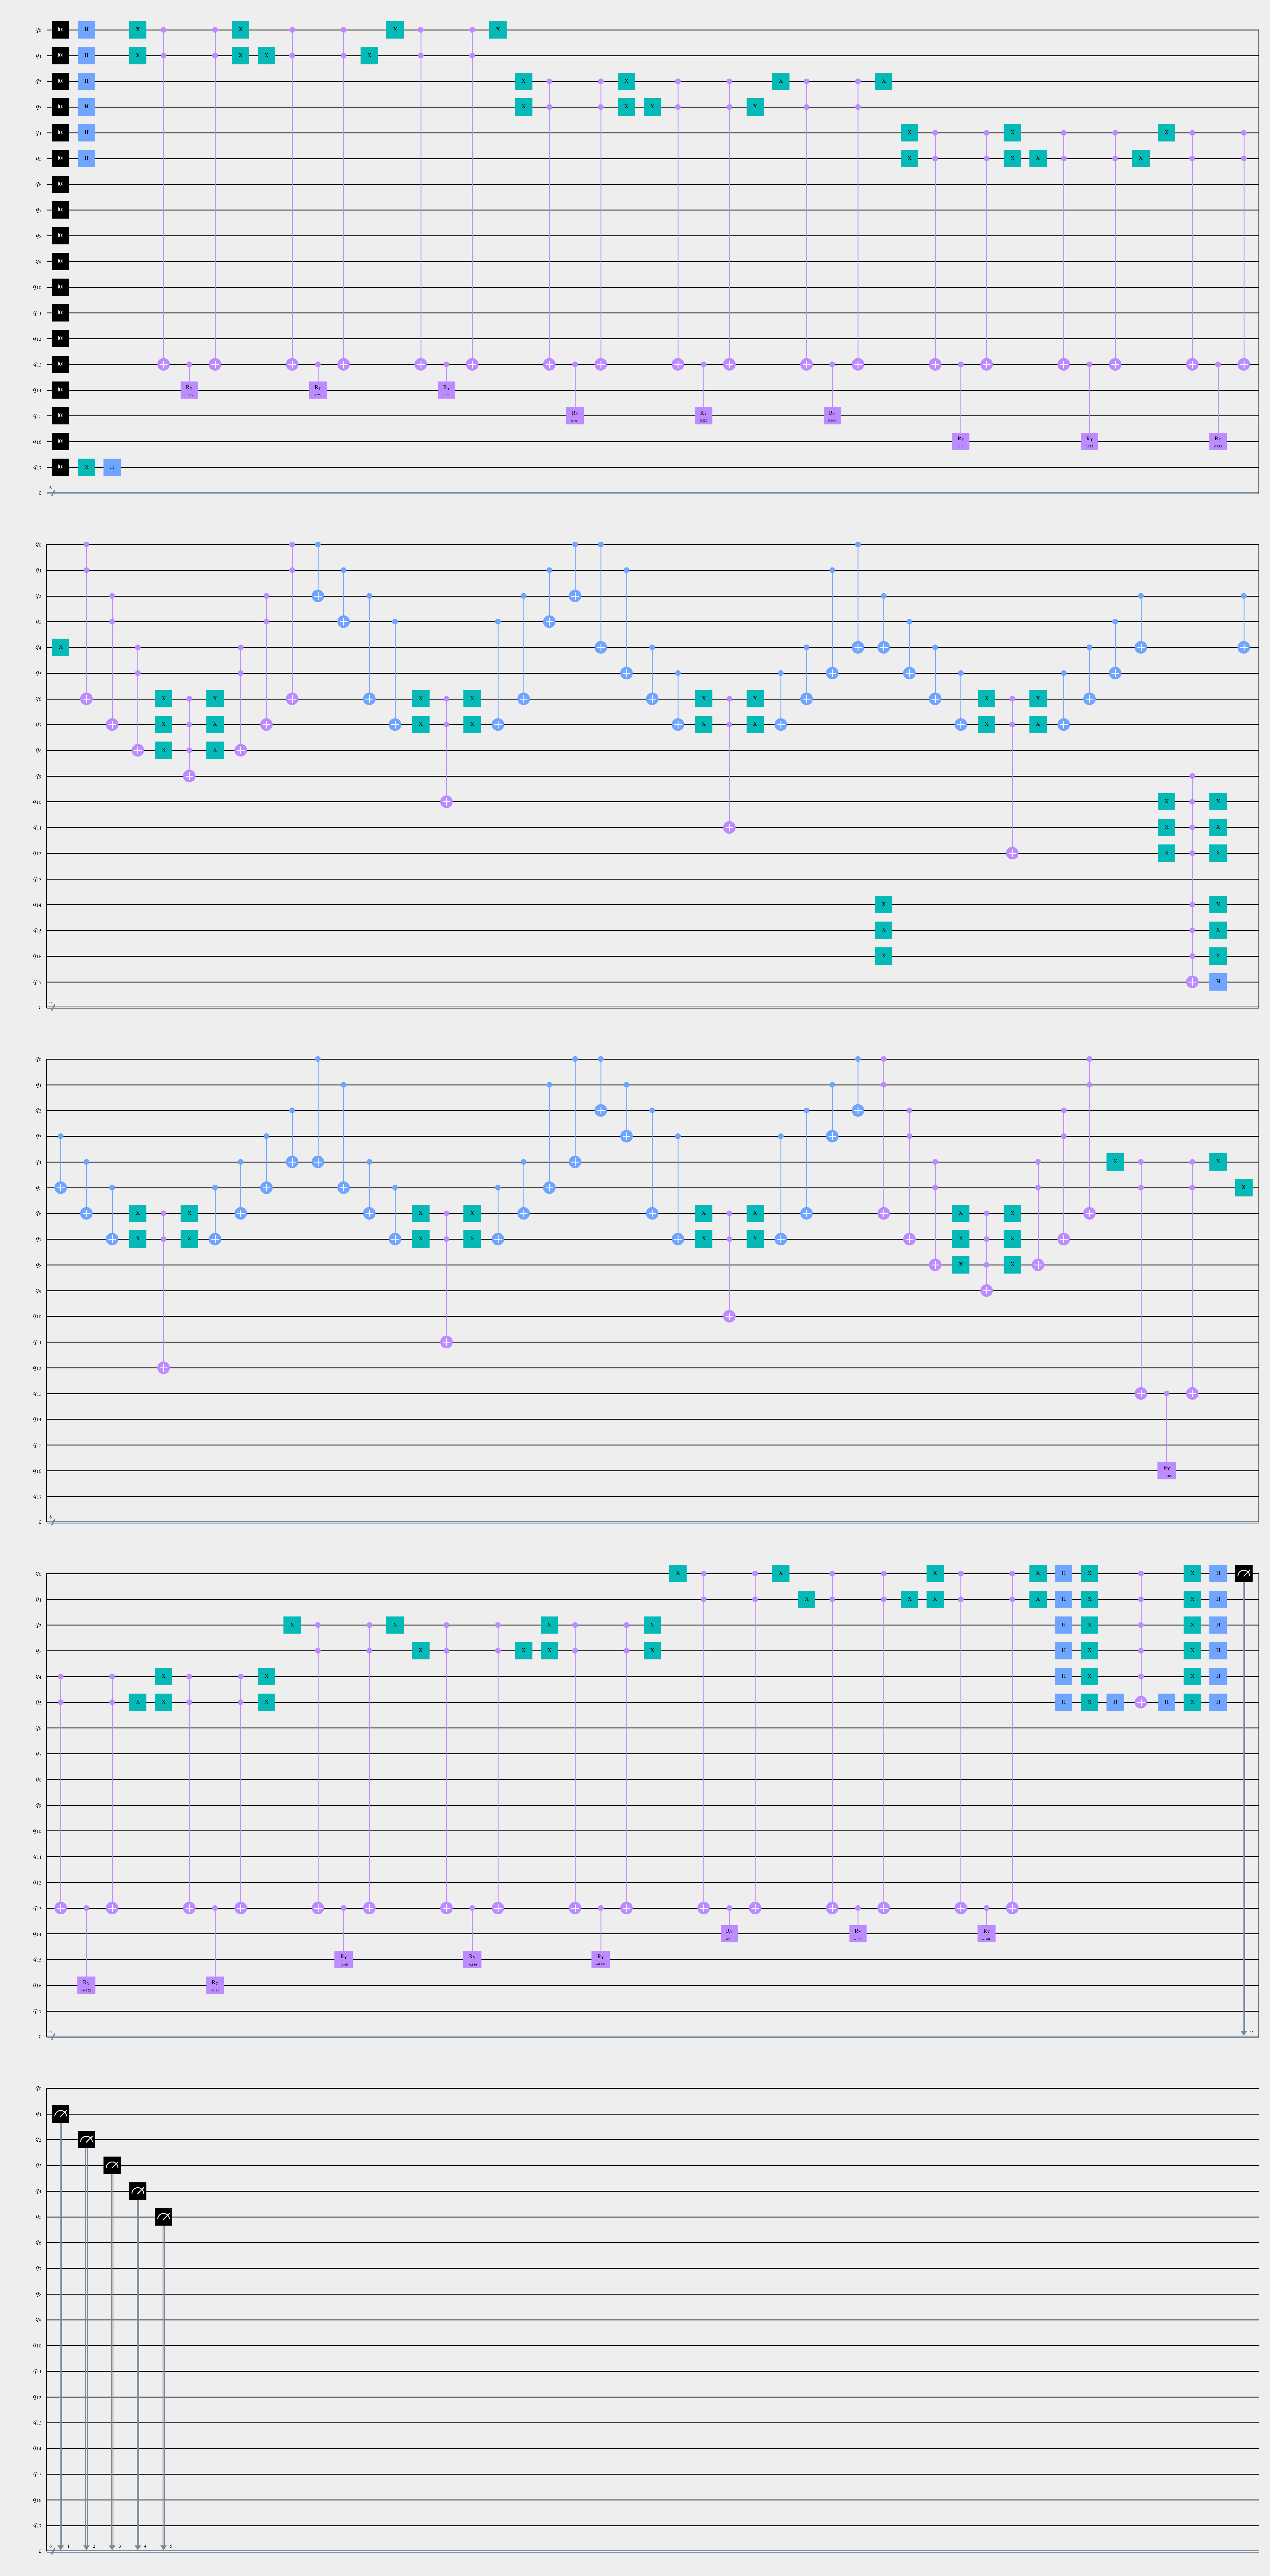

In [56]:
n_qubit = 18
n_matching = 6
grover_circuit = QuantumCircuit(n_qubit, n_matching)
grover_circuit.reset(range(0, 18))
grover_circuit = initialize_s(grover_circuit, n_qubit, n_matching)
for i in range(1):
    #1.249   1/10  9/10
    #1.1071   2/10  8/10
    #0.99116   3/10  7/10
    #0.88608   4/10  6/10
    #0.7854   5/10
    #0.68472   6/10  4/10
    #0.57964   7/10  3/10
    #0.46365   8/10  2/10
    #0.32175   9/10  1/10
    #0         10/10  0

    grover_circuit = rotate_a1(grover_circuit, n_qubit, 0.68472) # 6
    grover_circuit = rotate_a2(grover_circuit, n_qubit, 1.249)  #
    grover_circuit = rotate_a3(grover_circuit, n_qubit, 0.57964)
    grover_circuit = rotate_b1(grover_circuit, n_qubit, 0.99116)
    grover_circuit = rotate_b2(grover_circuit, n_qubit, 0.88608)
    grover_circuit = rotate_b3(grover_circuit, n_qubit, 0.46365)
    grover_circuit = rotate_c1(grover_circuit, n_qubit, 1.1071)
    grover_circuit = rotate_c2(grover_circuit, n_qubit, 0.32175)
    grover_circuit = rotate_c3(grover_circuit, n_qubit, 0.7854)
    grover_circuit = violate_state(grover_circuit, n_qubit)
    grover_circuit = compare_node1_node2(grover_circuit, n_qubit)
    grover_circuit = compare_node1_node3(grover_circuit, n_qubit)
    grover_circuit = compare_node2_node3(grover_circuit, n_qubit)
    grover_circuit.barrier([8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([7, 8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([6, 7, 8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([5, 6, 7, 8, 9, 10, 11, 12, 13])
    #grover_circuit.barrier([7, 8, 9, 10, 11, 12, 13, 14, 15])
    #grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
    grover_circuit.x([10, 11, 12, 14, 15, 16])
    grover_circuit.mcx([9, 10, 11, 12, 14, 15, 16], n_qubit-1)
    grover_circuit.x([10, 11, 12, 14, 15, 16])
    grover_circuit.h([n_qubit-1])
    grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    grover_circuit = compare_node2_node3(grover_circuit, n_qubit)
    grover_circuit = compare_node1_node3(grover_circuit, n_qubit)
    grover_circuit = compare_node1_node2(grover_circuit, n_qubit)
    grover_circuit = violate_state(grover_circuit, n_qubit)
    grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    grover_circuit = rotate_c3(grover_circuit, n_qubit, -0.7854)
    grover_circuit = rotate_c2(grover_circuit, n_qubit, -0.32175)
    grover_circuit = rotate_c1(grover_circuit, n_qubit, -1.1071)
    grover_circuit = rotate_b3(grover_circuit, n_qubit, -0.46365)
    grover_circuit = rotate_b2(grover_circuit, n_qubit, -0.88608)
    grover_circuit = rotate_b1(grover_circuit, n_qubit, -0.99116)
    grover_circuit = rotate_a3(grover_circuit, n_qubit, -0.57964)
    grover_circuit = rotate_a2(grover_circuit, n_qubit, -1.249)
    grover_circuit = rotate_a1(grover_circuit, n_qubit, -0.68472)
    grover_circuit = diffuser(grover_circuit, 6, n_qubit)
# for i in range(1):
#     #grover_circuit = violate_state(grover_circuit)
#     grover_circuit.append(violate_state(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#     grover_circuit.append(compare_node1_node2(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#     grover_circuit.append(compare_node1_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
#     grover_circuit.append(compare_node2_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#     grover_circuit.x([10, 11, 12])
#     grover_circuit.mcx([9, 10, 11, 12], 13)
#     grover_circuit.x([10, 11, 12])
#     grover_circuit.h([13])
#     grover_circuit.append(compare_node2_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#     grover_circuit.append(compare_node1_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
#     grover_circuit.append(compare_node1_node2(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#     grover_circuit.append(violate_state(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#     grover_circuit.append(diffuser(6), [0, 1, 2, 3, 4, 5])
    
grover_circuit.measure([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
#grover_circuit.draw(output = "mpl")
grover_circuit.draw(output='mpl', scale = 1.0, fold = 47, style={'backgroundcolor': '#EEEEEE'}, filename = "weighted3x3circuit.jpeg", plot_barriers = False)

In [57]:
from qiskit import BasicAer, Aer,execute
sim = Aer.get_backend('aer_simulator_statevector')
sim.set_options(device='CPU')
#sim = Aer.get_backend('aer_simulator')

In [58]:
job = execute(grover_circuit, backend = sim, shots = 100000)

In [59]:
counts = job.result().get_counts()

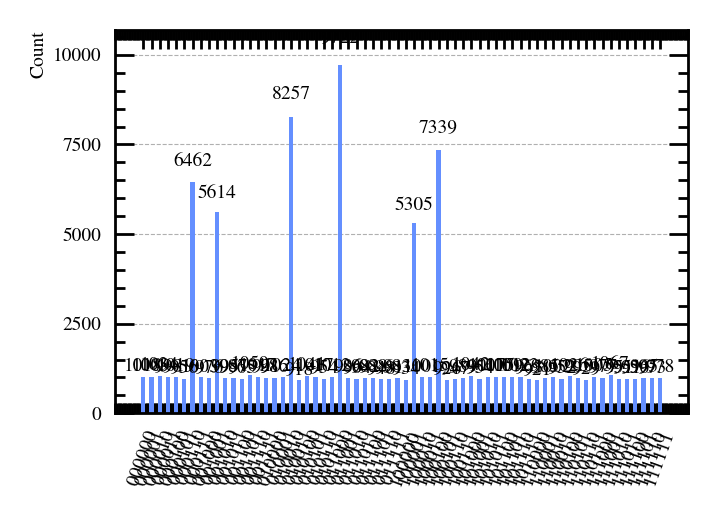

In [60]:
plot_histogram(counts)

In [61]:
type(counts)

qiskit.result.counts.Counts

In [62]:
max(counts, key=counts.get)

'011000'

In [63]:
sorted(counts, key=counts.get, reverse = True)

['011000',
 '010010',
 '100100',
 '000110',
 '001001',
 '100001',
 '111001',
 '001101',
 '101000',
 '010100',
 '000010',
 '110100',
 '010001',
 '101110',
 '000100',
 '000000',
 '101010',
 '001110',
 '010101',
 '101011',
 '100011',
 '101101',
 '010111',
 '000001',
 '101100',
 '110111',
 '000111',
 '110010',
 '100010',
 '000011',
 '001010',
 '110101',
 '111101',
 '001111',
 '100111',
 '011100',
 '001011',
 '010000',
 '011001',
 '110001',
 '011111',
 '011011',
 '111111',
 '111000',
 '001000',
 '111110',
 '001100',
 '011010',
 '101111',
 '011110',
 '111100',
 '000101',
 '010110',
 '101001',
 '110011',
 '111011',
 '111010',
 '011101',
 '100110',
 '100000',
 '110110',
 '100101',
 '110000',
 '010011']